# LAB | Hyperparameter Tuning

**Load the data**

Finally step in order to maximize the performance on your Spaceship Titanic model.

The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

So far we've been training and evaluating models with default values for hyperparameters.

Today we will perform the same feature engineering as before, and then compare the best working models you got so far, but now fine tuning it's hyperparameters.

In [14]:
#Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
from sklearn.metrics import confusion_matrix

# Calcula y muestra una matriz de confusión utilizando Seaborn
def calcularMatrizConfusion(y_test, y_pred):    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(1,figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show

In [3]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
spaceship.dropna(inplace=True)
spaceship['Cabin'] = spaceship['Cabin'].str[0]
spaceship = spaceship.drop(columns=['PassengerId', 'Name'])

spaceship['CryoSleep'] = spaceship['CryoSleep'].astype(int)
spaceship['VIP'] = spaceship['VIP'].astype(int)

spaceship = pd.get_dummies(spaceship, columns = ['HomePlanet', 'Cabin', 'Destination'])

spaceship_boolean = spaceship.select_dtypes(include=['bool']).columns
spaceship[spaceship_boolean] = spaceship[spaceship_boolean].astype(bool).astype(int)

In [5]:
y = spaceship['Transported']
X = spaceship.drop(columns=['Transported'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Now perform the same as before:
- Feature Scaling
- Feature Selection


In [6]:
from sklearn.preprocessing import StandardScaler
normalizer = StandardScaler()
normalizer.fit(X_train)
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)

- Now let's use the best model we got so far in order to see how it can improve when we fine tune it's hyperparameters.

In [8]:
grd_boosting = GradientBoostingClassifier(n_estimators=100)
grd_boosting.fit(X_train_norm, y_train)
y_pred = grd_boosting.predict(X_test_norm)

- Evaluate your model

Accuracy: 0.7859304084720121
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       661
           1       0.76      0.83      0.80       661

    accuracy                           0.79      1322
   macro avg       0.79      0.79      0.79      1322
weighted avg       0.79      0.79      0.79      1322



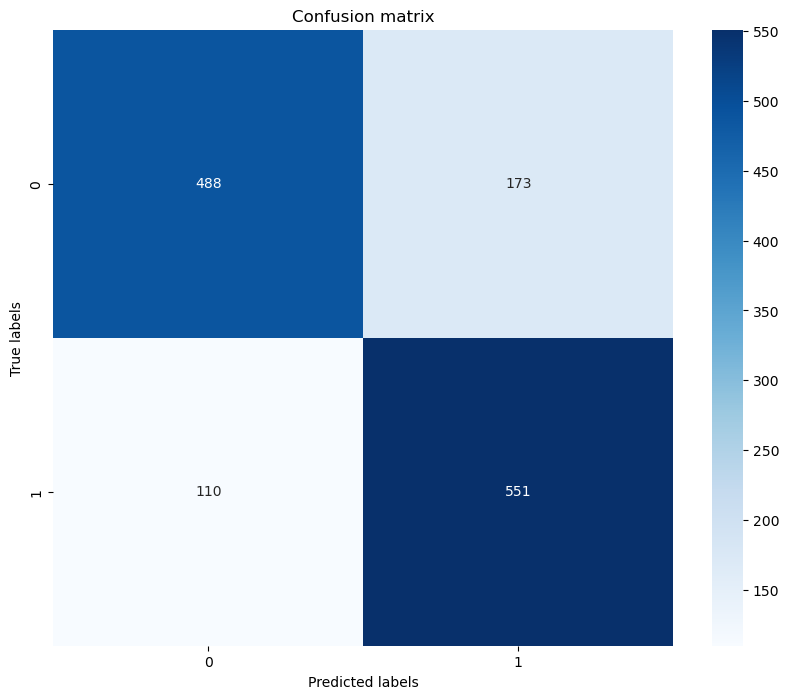

In [9]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
calcularMatrizConfusion(y_test, y_pred)

**Grid/Random Search**

For this lab we will use Grid Search.

- Define hyperparameters to fine tune.

In [11]:
grid = {
    'n_estimators': [100, 200, 300],         # Número de árboles
    'learning_rate': [0.01, 0.05, 0.1],      # Tasa de aprendizaje
    'max_depth': [3, 4, 5],                  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],         # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],           # Mínimo número de muestras en una hoja
    'subsample': [0.8, 0.9, 1.0]             # Proporción de muestras en cada iteración
}

In [12]:
gb_clf = GradientBoostingClassifier()

- Run Grid Search

In [15]:
model = GridSearchCV(estimator=gb_clf, param_grid=grid, cv=5)
model.fit(X_train_norm, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]})

- Evaluate your model

In [16]:
model.best_estimator_

GradientBoostingClassifier(max_depth=4, min_samples_split=10)

Accuracy: 0.7859304084720121
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       661
           1       0.76      0.83      0.80       661

    accuracy                           0.79      1322
   macro avg       0.79      0.79      0.79      1322
weighted avg       0.79      0.79      0.79      1322



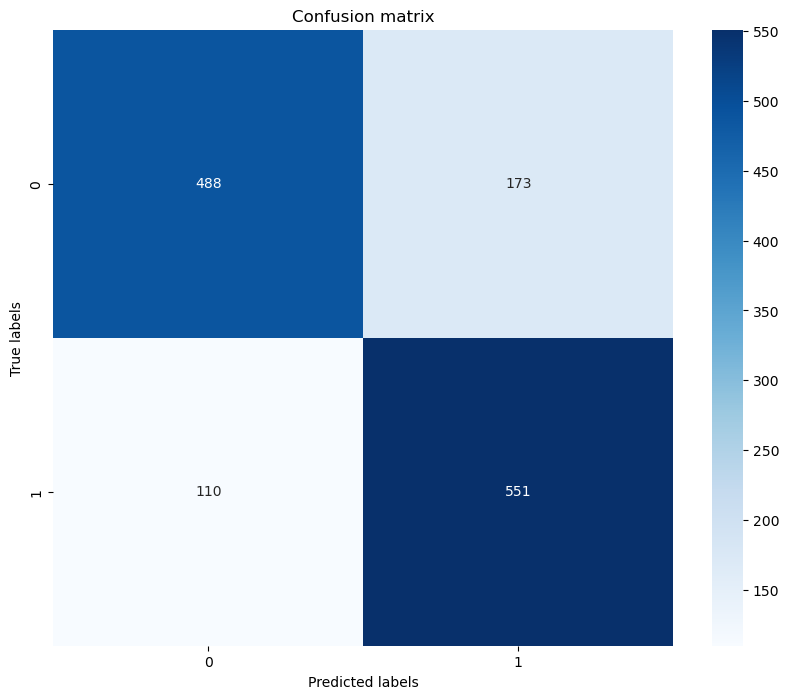

In [17]:
y_pred = grd_boosting.predict(X_test_norm)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
calcularMatrizConfusion(y_test, y_pred)